In [1]:
# importing basic library to wrangle and explore the data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

### Importing price series

 There are two distinct sets of data. The first pertains to Brazilian spot coffee, which encompasses the price of coffee traded within coffee production regions in Brazil. This coffee is referred to as 'green bean' coffee, representing the unroasted, raw form of the bean before it undergoes roasting and grinding for consumption. 
 
 The second series represents the future price of coffee, traded in exchange. This data series focuses on expected price of coffee at a later date, based on market expectations and trends.

In [2]:
# impoting the data
path = '/Users/marciobernardo/Documents/Springboard/Projects/3rd Capstone project/dados/'


df_bra_coffee = pd.read_csv(path+'coffee_brazil.csv') 

df_fut_coffee = pd.read_csv(path+'coffee_future.csv') 
                            

### Data Wrangling

Brazilian spot coffee is commercialized within Brazil and is quoted in Brazilian Reais per 60-kilo bag. The "coffee_brazil.csv" file already contains a column with quotes in US dollars per 60-kilo bag. However, the future coffee market quotes are given in US cents per pound. Therefore, the 'price_adj' column represents the conversion of US dollars per 60 kilos to US cents per pound.

In [3]:
# Brazilian spot coffee, quoted as US$ per 60 Kilos (US$/60 Kg)
df_bra_coffee = df_bra_coffee[['Data','À vista US$']].copy()

df_bra_coffee.columns = ['date','br_price']

df_bra_coffee['date'] = pd.to_datetime(df_bra_coffee['date'], format='%d/%m/%Y')

# Set 'date' column as the index
df_bra_coffee.set_index('date', inplace=True)

# Adjusting the Brazilian coffee price to cents/pounds
df_bra_coffee['br_price_adj'] = (df_bra_coffee['br_price']* 100/60)/2.20462

### Inspecting the Brazilian coffee series

In [4]:
df_bra_coffee.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6706 entries, 1996-09-02 to 2023-08-08
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   br_price      6706 non-null   float64
 1   br_price_adj  6706 non-null   float64
dtypes: float64(2)
memory usage: 157.2 KB


In [5]:
df_bra_coffee.head()

,br_price,br_price_adj
date,,
1996-09-02,121.15,91.587968
1996-09-03,117.69,88.972249
1996-09-04,117.44,88.783252
1996-09-05,116.38,87.981905
1996-09-06,115.98,87.679509


In [6]:
df_bra_coffee.describe()

,br_price,br_price_adj
count,6706.000000,6706.000000
mean,138.324032,104.571334
std,59.943326,45.316446
min,30.920000,23.375155
25%,103.730000,78.418654
50%,127.260000,96.207056
75%,169.137500,127.865951
max,349.390000,264.134711


In [7]:
# ICE future coffee, quoted as cents per pounds (c$/lb)

df_fut_coffee = df_fut_coffee[['Date','Last Price']].copy()

df_fut_coffee.columns = ['date','fut_price']

df_fut_coffee['date'] = pd.to_datetime(df_fut_coffee['date'], format='%m-%d-%y')

# Set 'date' column as the index
df_fut_coffee.set_index('date', inplace=True)

### Inspecting the Future coffee series

In [8]:
df_fut_coffee.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6836 entries, 1996-08-12 to 2023-08-08
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fut_price  6766 non-null   float64
dtypes: float64(1)
memory usage: 106.8 KB


In [9]:
df_fut_coffee.head()

,fut_price
date,
1996-08-12,116.15
1996-08-13,123.15
1996-08-14,121.30
1996-08-15,121.15
1996-08-16,120.85


In [10]:
df_fut_coffee.describe()

,fut_price
count,6766.000000
mean,129.856119
std,49.512300
min,41.500000
25%,101.950000
50%,121.250000
75%,153.337500
max,314.800000


### Merging the coffee series and calculating the Brazilian coffee basis (spot market - future market)

In [11]:
# Brazilian coffee basis calculation, quotes in cents per pound (c$/lb)
df_bra_basis = pd.merge(df_bra_coffee,df_fut_coffee, how='inner', left_index=True, right_index=True)

df_bra_basis['br_basis'] = df_bra_basis.br_price_adj - df_bra_basis.fut_price 

df_bra_basis.dropna(inplace = True)


DataFrame named 'df_bra_basis' includes the Brazilian spot market, quoted in US dollar per 60 Kile bag and the adjusted Brazilian spot market, the future market, and the Brazilian coffee basis time series, quoted in US cents per pound.

The basis is derived from the difference between the spot market and the future market. This series indicates the residual market risk that remains even after implementing a hedge. While a hedge reduces market risk, it doesn't eliminate it entirely. Basis risk signifies the market risk that cannot be completely eliminated. The basis is also crucial in calculating the optimal hedging ratio.

In [12]:
# Saving the basis dataframe to a csv file
df_bra_basis.to_csv(path + 'bra_basis.csv', index_label='date')

### EDA

In [13]:
df_bra_basis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6515 entries, 1996-09-03 to 2023-08-08
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   br_price      6515 non-null   float64
 1   br_price_adj  6515 non-null   float64
 2   fut_price     6515 non-null   float64
 3   br_basis      6515 non-null   float64
dtypes: float64(4)
memory usage: 254.5 KB


The dataset spans from September 3rd, 1996, to August 8th, 2023, comprising a total of 6515 observations in our time series. There are four distinct series within the dataset: the Brazilian spot market (quoted in US$/60 kilo), the adjusted price for the Brazilian spot market (quoted in US cents per pound), the ICE coffee future price (quoted in US cents per pound), and the Brazilian coffee basis series (quoted in US cents per pound).

In [14]:
df_bra_basis.head()

,br_price,br_price_adj,fut_price,br_basis
date,,,,
1996-09-03,117.69,88.972249,125.05,-36.077751
1996-09-04,117.44,88.783252,124.20,-35.416748
1996-09-05,116.38,87.981905,122.60,-34.618095
1996-09-06,115.98,87.679509,124.60,-36.920491
1996-09-09,115.11,87.021800,122.50,-35.478200


In [15]:
df_bra_basis.describe()

,br_price,br_price_adj,fut_price,br_basis
count,6515.000000,6515.000000,6515.000000,6515.000000
mean,138.433088,104.653779,129.811604,-25.157825
std,59.825587,45.227437,49.486644,9.009344
min,30.920000,23.375155,41.500000,-98.992103
25%,103.840000,78.501813,101.875000,-29.039687
50%,127.380000,96.297775,121.100000,-23.507018
75%,169.150000,127.875401,153.350000,-19.279366
max,349.390000,264.134711,304.900000,3.641727


The basic descriptive statistics reveal that the basis series exhibits significantly lower volatility (as indicated by the lowest standard deviation) and has the narrowest range. These findings align with the concept that basis risk is notably lower than the inherent risk associated with either the spot or future market. In addition, we can observe that the Brazilian coffee basis is negative most of the time.

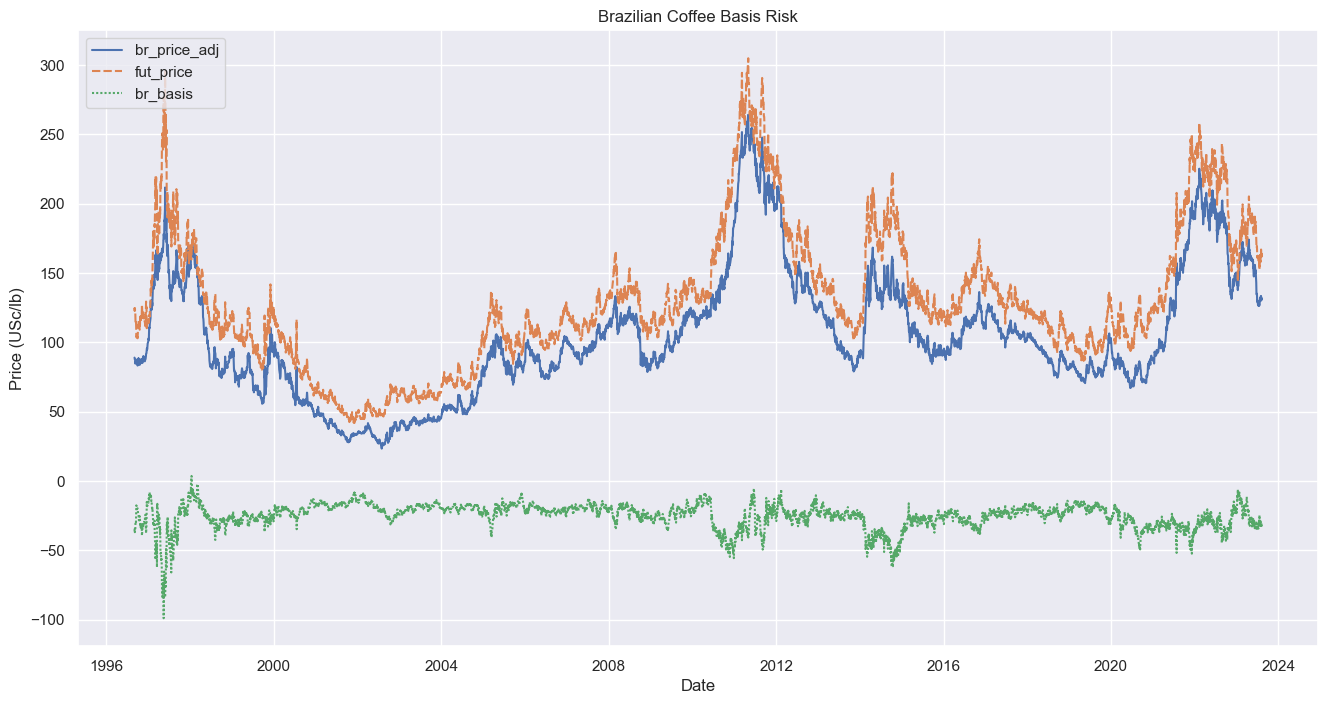

In [16]:

# Set the style
sns.set(style="darkgrid")

# Plot the line chart using Seaborn for specific columns
plt.figure(figsize=(16, 8))  # Adjust the figure size if needed
sns.lineplot(data=df_bra_basis[['br_price_adj', 'fut_price', 'br_basis']])
plt.xlabel('Date')
plt.ylabel('Price (USc/lb)')
plt.title('Brazilian Coffee Basis Risk')
plt.legend(loc='upper left')
plt.show();


The chart depicting the price series visually illustrates the diminished volatility and range of the basis in comparison to both the future market and the spot market. While both the future and spot markets displayed substantial price fluctuations over the analyzed time period, the basis has consistently remained relatively stable around the -23 level.

Furthermore, this graph also highlights periods of increased volatility, distinct trends over the years, and some discernible seasonality.

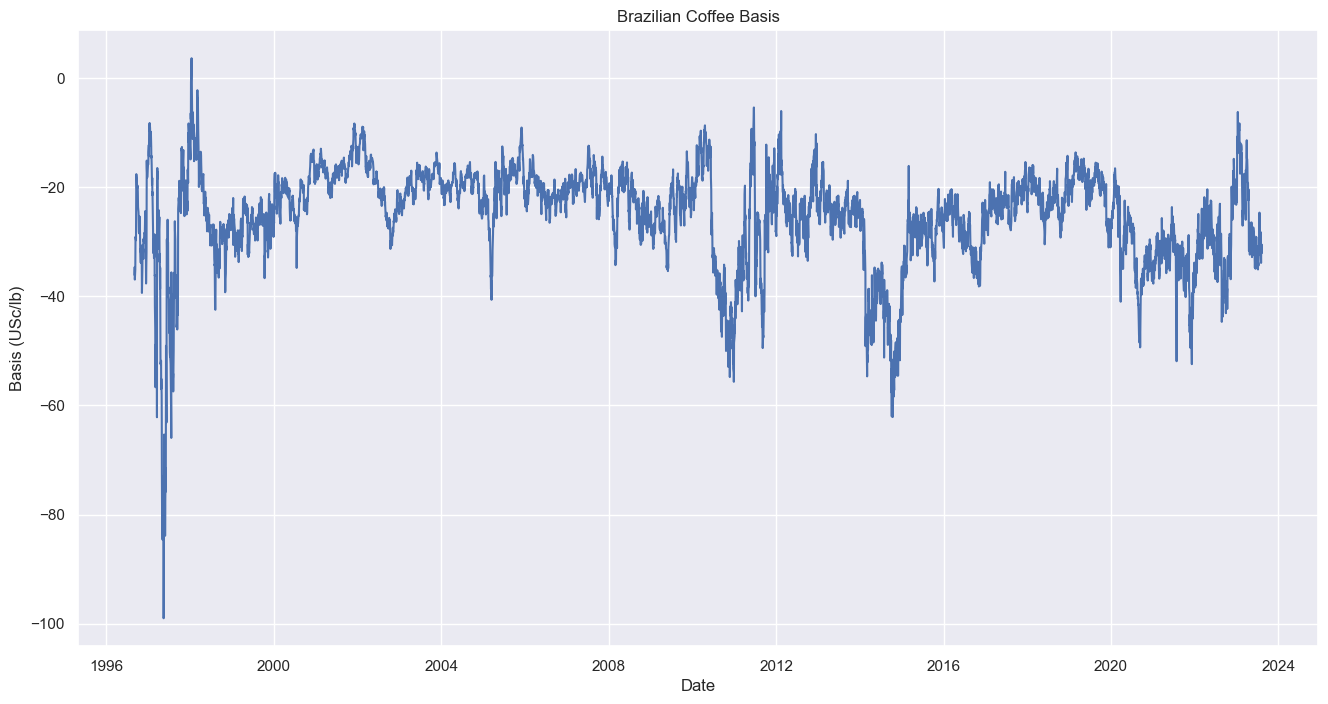

In [17]:
# Set the style
sns.set(style="darkgrid")

# Plot the line chart using Seaborn for the 'bra_basis' column
plt.figure(figsize=(16, 8))  # Adjust the figure size if needed
sns.lineplot(data=df_bra_basis['br_basis'])
plt.xlabel('Date')
plt.ylabel('Basis (USc/lb)')
plt.title('Brazilian Coffee Basis')
plt.show()


The chart of the Brazilian coffee basis series reveals that, while the basis exhibits considerably less volatility, this series also demonstrates clusters of increased volatility, distinct trends, and seasonal and cyclical patterns.

### Testing time series stationarity

In [18]:
# Testing time series stationarity

adf_tests_results = [adfuller(df_bra_basis[column])[1] for column in df_bra_basis.columns]

In [19]:
for result in zip(df_bra_basis.columns,adf_tests_results):
    print(f'ADF test p-value for {result[0]:<12}: {round(result[1],6)}')

ADF test p-value for br_price    : 0.236172
ADF test p-value for br_price_adj: 0.236172
ADF test p-value for fut_price   : 0.142893
ADF test p-value for br_basis    : 2.6e-05


Brazilian basis is the only series that is likely stationary based on the ADF test, while the others series (br_price, br_price_adj, and fut_price) are likely non-stationary.

In [20]:
df_bra_basis.corr()

,br_price,br_price_adj,fut_price,br_basis
br_price,1.000000,1.000000,0.985920,-0.395414
br_price_adj,1.000000,1.000000,0.985920,-0.395414
fut_price,0.985920,0.985920,1.000000,-0.543438
br_basis,-0.395414,-0.395414,-0.543438,1.000000


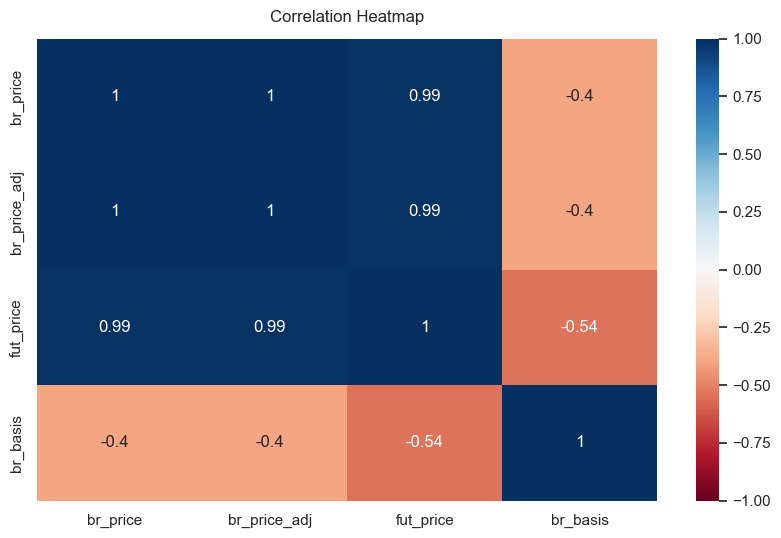

In [21]:
# Correlation Analysis

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap using seaborn
heatmap = sns.heatmap(df_bra_basis.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Show the plot
plt.show()

In [22]:
skew = df_bra_basis.skew()
kurtosis = df_bra_basis.kurtosis()
range = df_bra_basis.max() - df_bra_basis.min()
cv = df_bra_basis.std()/df_bra_basis.mean()
mad = np.abs(df_bra_basis - df_bra_basis.mean()).mean()

# Create a DataFrame with the calculated statistics
result_table = pd.DataFrame({
    'Skew': skew,
    'Kurtosis': kurtosis,
    'Range': range,
    'Coefficient of Variation.': cv,
    'Mean Absolute Deviation': mad
})

# Display the result table
display(result_table)

,Skew,Kurtosis,Range,Coefficient of Variation.,Mean Absolute Deviation
br_price,0.806834,0.703527,318.470000,0.432162,45.684566
br_price_adj,0.806834,0.703527,240.759556,0.432162,34.536992
fut_price,0.748859,0.466337,263.400000,0.381219,37.588125
br_basis,-1.576403,5.625130,102.633830,-0.358113,6.582702


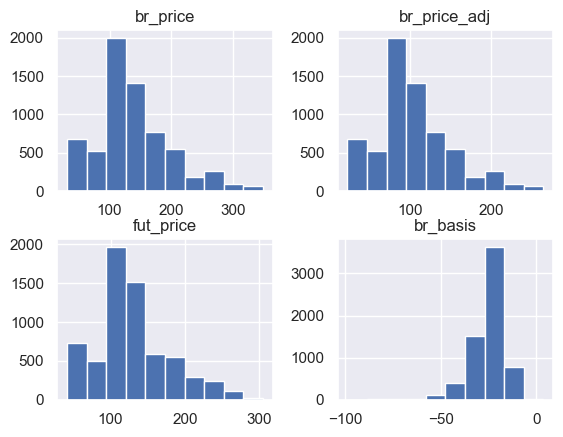

In [23]:
df_bra_basis.hist();

Based on the information presented in the report above, we can deduce that the Brazilian coffee basis risk exhibits a strong correlation with the adjusted Brazilian spot market price and the coffee future price. Moreover, the series is non-stationary and displays seasonality.

The coffee basis has the lowest coefficient of variation (-0.35) and the lowest mean absolute deviation (6.58) among the series. It also demonstrates excess kurtosis and slight skewness. The histagram of the basis looks like an assimetric t-student distribution. The mean of the basis is -25.16, with a median of -23.04.

In [39]:
df_bra_basis.columns

Index(['br_price', 'br_price_adj', 'fut_price', 'br_basis'], dtype='object')

### Decomposition of the Brazilian Coffee Basis Series

In [40]:
basis = df_bra_basis['br_basis'].rolling(window=21,center=True,win_type='triang').mean()
basis = basis.to_frame()
basis['doy'] = basis.index.dayofyear
basis['year'] = basis.index.year

In [42]:

piv_basis = pd.pivot_table(basis,index=['doy'],columns=['year'], values = ['br_basis'])

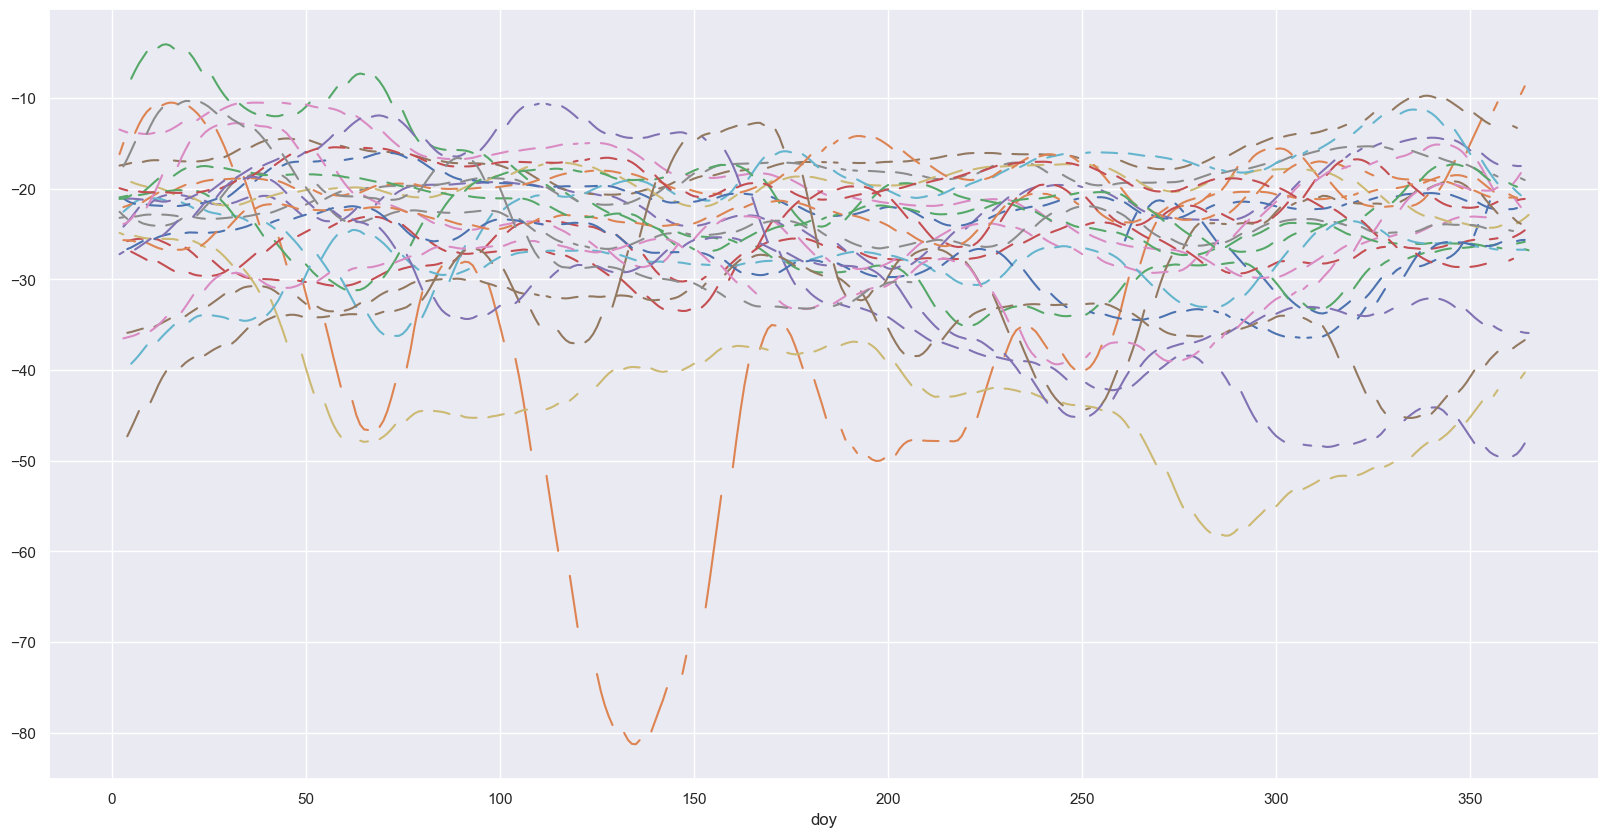

In [43]:
piv_basis.plot(figsize=(20, 10), legend = False);

The seasonality pattern isn't very clear. However, from an economic perspective, the seasonality would likely be multiplicative. Given the current conditions that already impact the market price, a seasonal effect would probably influence the price in a proportional manner rather than through a fixed added effect.

In [45]:
# Taken the absolute value of the Brazil coffee bases because the multiplicable model doesn't allow negative numbers.
basis_decom = seasonal_decompose(abs(df_bra_basis['br_basis']), model='multiplicable', period = 251)


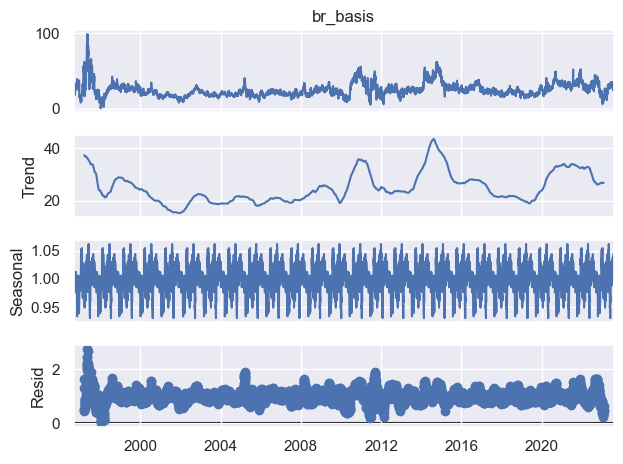

In [46]:
basis_decom.plot();

Conclusion:

The Brazilian coffee basis time series has typical financial time series properties, statistical test show that the series isn't stationary and has seasonality. Therefore, the SARIMA is a good baseline method to explore this data.